In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# data loading

In [58]:
X_train = pd.read_csv("../NEO-Hazard-Predictor/data/processed/X_train.csv")
y_train = pd.read_csv("../NEO-Hazard-Predictor/data/processed/y_train.csv")
X_test = pd.read_csv("../NEO-Hazard-Predictor/data/processed/X_test.csv")
y_test = pd.read_csv("../NEO-Hazard-Predictor/data/processed/y_test.csv")

# logistic regression

training the model is straightforward already (fit then predict)

In [59]:
logr = LogisticRegression()
logr.fit(X_train, y_train.values.ravel())

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [60]:
predictions = logr.predict(X_test)
probabilities = logr.predict_proba(X_test) 

In [61]:
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
precision = precision_score(y_test, predictions)
print(f"Model precision: {precision}")
recall = recall_score(y_test, predictions)
print(f"Model recall: {recall}")
Confusion_Matrix = confusion_matrix(y_test, predictions)
print(f"Model confusion_matrix: \n{Confusion_Matrix}")

Model Accuracy: 0.7861074416556583
Model precision: 0.30439601034355374
Model recall: 0.9321266968325792
Model confusion_matrix: 
[[12634  3766]
 [  120  1648]]


```text
at first glance this look terrible but believe it or not that is actually a decent results for a very basic model like logistic regression
next step is trying more complicated classification algorithms like decision trees and boosting
```

# random forest classifier 

## training and evaluation

In [62]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train.values.ravel())

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [63]:
y_train_pred = rand_forest.predict(X_train)
y_test_pred = rand_forest.predict(X_test)

In [64]:
print("=== THE OPEN-BOOK TEST (TRAINING DATA) ===")
print("If Recall here is 1.00, the model perfectly memorized the data.")
print(classification_report(y_train, y_train_pred))

print("\n" + "="*50 + "\n")

print("=== THE FINAL EXAM (TESTING DATA) ===")
print("If Recall here crashes, the memorized rules failed in the real world.")
print(classification_report(y_test, y_test_pred))

=== THE OPEN-BOOK TEST (TRAINING DATA) ===
If Recall here is 1.00, the model perfectly memorized the data.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65596
           1       1.00      1.00      1.00     65596

    accuracy                           1.00    131192
   macro avg       1.00      1.00      1.00    131192
weighted avg       1.00      1.00      1.00    131192



=== THE FINAL EXAM (TESTING DATA) ===
If Recall here crashes, the memorized rules failed in the real world.
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     16400
           1       0.48      0.62      0.54      1768

    accuracy                           0.90     18168
   macro avg       0.72      0.77      0.74     18168
weighted avg       0.91      0.90      0.90     18168



## tuning the model

```text
look at the results they are even worse but that is the base random forest classifier to get better results we will have to tune the params of the model as follows
```

```text
but which params do we choose to tune from many we cant tune thro all the params that would be a waste of time and computational power  
we will decide which params we tune by defining the problem we are facing and to do so we will need to have a thorough look at our evaluation.  
here because of the nature of random forest with no tuning it went so deep with branches that it memories every single sample that is why we get perfect scores   
that is called **over-fitting**.  
and the low recall means that the is biased to the majority class even tho we oversampled it using smote
the next step is deciding which params need to be tuned   
```

```text 
The "Three Bucket" Rule   
Every machine learning algorithm in existence—from a simple SVM to a billion-parameter Deep Learning Neural Network—has hyperparameters that fall into three physical buckets. When you open the documentation for a new model, you just scan the page looking for the parameters that fit these descriptions:  
    - Bucket 1: The Size/Power. (How big is the engine?)  
        Keywords to look for: n_estimators, epochs, hidden_layers, iterations.  
    - Bucket 2: The Brakes / Regularization. (How do we stop it from memorizing/overfitting?)  
        Keywords to look for: max_depth, penalty, alpha, C, learning_rate, dropout.  
    - Bucket 3: The Imbalance Fix. (How do we make it care about the minority class?)  
        Keywords to look for: class_weight, scale_pos_weight.  
    
    If you can find just one parameter from each of those three buckets, you have found the 20% that controls 80% of the model. You can completely ignore the rest.   

The "User Guide" Shortcut
    If you ever get stuck, do not read the raw API documentation. Read the User Guide.  
    In Scikit-Learn (and XGBoost, LightGBM, etc.), the creators always write a narrative "User Guide" page. On that page, they will explicitly tell you: "The most important parameters to tune are X and Y." They literally give you the cheat codes.  
```

```text
**Key Hyperparameters for Tuning**
Hyperparameters allow you to control the model's complexity and performance. The scikit-learn documentation provides a comprehensive list. 
n_estimators: The number of trees in the forest. A higher number generally leads to better accuracy but increases computation time.
max_depth: The maximum depth of each tree. Limiting depth helps control overfitting.
max_features: The number of features considered when looking for the best split at each node. The default is often sqrt or log2(total_features).
min_samples_leaf: The minimum number of samples required to be at a leaf node. Increasing this can reduce overfitting.
criterion: The function to measure the quality of a split, commonly 'gini' or 'entropy'. 

using this user guide (cheat sheet) we can safely say that the most important params are "n_estimators", "max_depth"  for solving the overfitting and "class_weight" for solving the bias problem
```

In [65]:
# the first thing defining the parameters "Engine Parts" we want to test
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'class_weight': ['balanced', 'balanced_subsample'] 
}

In [66]:
# this part iterates the model using params combinations that we defined in the param grid
# here we use randomized grid search just to save some time
rf_search = RandomizedSearchCV(
    estimator=rand_forest, 
    param_distributions=param_grid, 
    n_iter=10,             # It will randomly test 10 different combinations
    scoring='recall',      # OPTIMIZING FOR RECALL!
    cv=3, 
    random_state=42,
    n_jobs=-1             
)

In [67]:
rf_search.fit(X_train, y_train.values.ravel())

,estimator,RandomForestClassifier()
,param_distributions,"{'class_weight': ['balanced', 'balanced_subsample'], 'max_depth': [5, 10, ...], 'n_estimators': [100, 200, ...]}"
,n_iter,10
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


returning the best params for the grid search

In [68]:
best_rf = rf_search.best_estimator_
print(f"\nBest Engine Parameters Found: {rf_search.best_params_}")


Best Engine Parameters Found: {'n_estimators': 300, 'max_depth': 10, 'class_weight': 'balanced'}


## best model

after getting the best params for the model use them

In [77]:
best_rand_forest = RandomForestClassifier(n_estimators=300, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42)
best_rand_forest.fit(X_train, y_train.values.ravel())

,n_estimators,300
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [78]:
y_pred_best = best_rand_forest.predict(X_test)

plotting the confusion matrix and the report for the new tuned model

<Figure size 800x600 with 0 Axes>

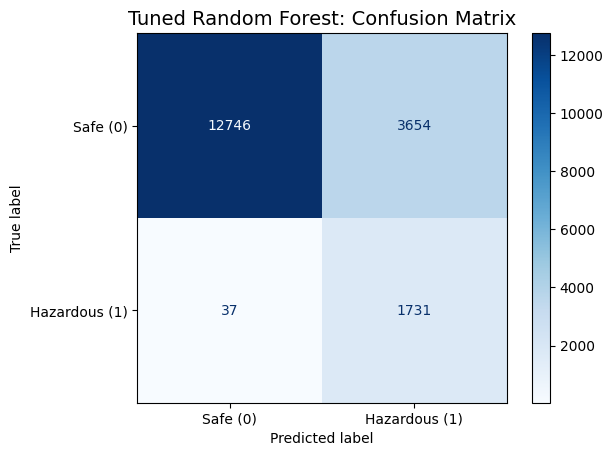


--- Tuned Random Forest Report ---
              precision    recall  f1-score   support

           0       1.00      0.78      0.87     16400
           1       0.32      0.98      0.48      1768

    accuracy                           0.80     18168
   macro avg       0.66      0.88      0.68     18168
weighted avg       0.93      0.80      0.84     18168



In [79]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe (0)', 'Hazardous (1)'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Tuned Random Forest: Confusion Matrix", fontsize=14)
plt.grid(False)
plt.show()

# Print the new report
print("\n--- Tuned Random Forest Report ---")
print(classification_report(y_test, y_pred_best))

look at that confusion matrix the model misses less of the hazardous objects but causes a lot more false alarms   
but in the real world having a 4k false alarms is a lot better than a single world threat